In [1]:
from information_geometry import *

# **Information Geometry and Statistical Manifolds**
## *Noeloikeau Charlot 9/30/22*

Here we study *information geometry*, a framework for quantifying the geometry of probability distributions. The objects of interest are *statistical manifolds*, which are spaces of probability distributions smoothly connected by changes in parameters. The distance between nearby probability distributions on the manifold is interpreted as their difference in information content with respect to a varied parameter. As a result, the shape ensuing from all possible parameter variations about a point exactly characterizes the "latent" information content of the distribution. This is analogous to paths taken by light being used to characterize a gravitational field -- except that the curvature of the space arises from a distribution of probability, not mass, and the paths are in parameter space, not spacetime. 

We consider normalized probability density functions $f(x,a):R^D\times R^M\rightarrow R$ such that $\int_{X} f(x,a) dx = 1$, where

> $x$ : D-dimensional random variable;

> $a$ : M-dimensional distribution parameter;

> $X=R^{D \times N}$ : sample domain of observations of $x$, taken as $N\rightarrow \infty$. 

The metric $g_{ij}(a)$ in this space is the Fisher information matrix. Its components are products of the partial derivatives of the probability distribution with respect to the parameter axes, evaluated at a particular point in parameter space. It is computed from the logarithm of the reciprocal probability (i.e. the information $I$): 

> $I(x,a) = - \log[f(x,a)]$

The Fisher information quantifies the difference between infinitesimally distinct probability distributions. Each component gives the distance (in bits base $e$) between nearby points on a statistical manifold. It can be interpreted as the change in KL-divergence between two probability distributions as a result of infinitesimally varying parameters $a_{i}$ and $a_{j}$ about point $a$ and "integrating out" the sample space $X$:

> $g_{ij}(a) =  \int_{X} [\partial_{a_{i}}I(x,a)][\partial_{a_{j}}I(x,a)] f(x,a) dx $
>            := $\langle I_{i}I_{j} \rangle$

where $\partial_{i}I:=I_{i}$ is an element of the Jacobian, and $\langle (.) \rangle = \int_{X}(.)p(x,a)dx$.

It can be showed that $\langle I_{i}I_{j} \rangle = \langle I_{ij} \rangle$, i.e. that the expectation values of the Hessian $\partial_{i}\partial_{j}I:=I_{ij}$ and products of the Jacobian are equal under this metric. Therefore $g_{ij}(a)$ can be computed from either. Additionally $\langle I_{i} \rangle = 0$, which can be obtained by differentiating the normalization condition (see https://arxiv.org/pdf/1310.1831.pdf). These constraints are useful for evaluating the accuracy of numerical approaches to computing the metric, as is done here.

The partial derivatives of the metric give the geodesic equations and define the curvature of the space. This curvature can be interpreted as the "latent" information stored in the derivatives of the distribution with respect to its parameter vectors. Geodesics minimize the distance between distributions and can be used to smoothly interpolate between points on a manifold. In other words, successive changes in a probability distribution along a geodesic are minimized.

Analytically it can be shown that for the Fisher information metric the metric derivatives are:
> $\partial_{k}g_{ij} = \langle -I_{i}I_{j}I_{k}+I_{i}I_{kj}+I_{j}I_{ki}\rangle$. 

The connection coefficients relate the metric derivatives to the geodesic acceleration by means of a linear combination of functions. These Christoffel symbols are defined by:
> $\Gamma^{l}_{ij} = \frac{1}{2}g^{lk} \langle \partial_{i}g_{kj}+\partial_{j}g_{ki}-\partial_{k}g_{ij} \rangle$
>                  = $g^{lk} \langle I_{ij}I_{k}-\frac{1}{2}I_{i}I_{j}I_{k}\rangle$

where the second equality is the analytic solution obtained for the Fisher information metric specifically, and $g^{lk}$ is the inverse matrix of $g_{lk}$. Note the implicit summation over repeated indices.

The geodesic equations are finally:
>   $\ddot{a}^{l} = -\Gamma^{l}_{ij}\dot{a}^{i}\dot{a}^{j}$

where $\dot{a}^{l}=\frac{da^{l}}{dt}$ is the derivative of the $l$'th component of $a$ with respect to the affine parameter of the geodesic path $t$. These equations are an initial value problem specified by the initial point in parameter space $a_{0}$, the initial tangent vector $\dot{a}_{0}$, and the number of steps along the affine path of the geodesic $T$. Note the initial tangents are contravariant vectors that must be normalized by the metric at that point:

>   $|\dot{a}_{0}|^{2}=g_{ii}(a_{0})\dot{a}_{0}^{i}\dot{a}_{0}^{i}$. 

The solution is obtained numerically using a 1st-order finite-difference method (Euler). The geodesic path is parametrized in terms of an affine, unit interval of $T$ points $t\in[0,1]$ such that $dt=\frac{1}{T}$. The resulting algorithm is:

>   $a^{l}(t+1) = a^{l}(t) + dt \cdot \dot{a}^{l}(t)$

>   $\dot{a}^{l}(t+1) = \dot{a}^{l}(t) + dt \cdot F^{l}(a(t),\dot{a}(t))$

>   $F^{l}(a(t),\dot{a}(t))=  -\sum_{i,j}\Gamma^{l}_{ij}(a(t)) \cdot \dot{a}^{i}(t)\dot{a}^{j}(t)$.

All other derivatives are computed numerically using 2nd-order finite-differences (perturbations above and below the given vector). 

## Normal Distribution
The Normal or Gaussian distribution is given by

>   $a=(\mu,\sigma)$

>   $f(x,a) = \exp[(\frac{x-\mu}{\sigma})^2]$ 

where $a$ is the parameter vector giving the mean and standard deviation, and $f$ is the un-normalized probability density function (PDF). The analytic solution to the normalization factor is $f\rightarrow f\cdot[\sigma\sqrt{2\pi}]^{-1}$. Numerical normalization is possible by integrating over the points in the domain for which the function is not zero (its support). For example, consider the parameter vector $a=(0,1)$. To within small error the support of the function lies within $5\sigma$ of the mean $\mu=0$. We can calculate the normalization numerically by integrating over $x\in[-5,5]$ using $10^{4}$ evenly spaced points and divide by the sum to get the normalized PDF, as in the following (see source code):

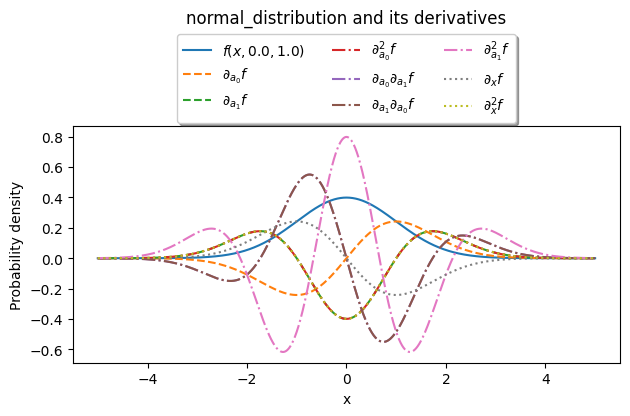

In [2]:
sm=StatisticalManifold(normal_distribution,normalize=True,
                       a=np.array([0,1.0]) #0 mean, 1 std
                       )
sm.plot() #the StatisticalManifold class implicitly calculates the Jacobian and Hessian at "a"

Note how $\partial_{x}f = -\partial_{\mu}f$. This is due to the symmetry of the argument in the normal distribution $(\frac{x-\mu}{\sigma})$. 

Further note that the cross-partials commute $\partial_{a_{0}}\partial_{a_{1}}f=\partial_{a_{1}}\partial_{a_{0}}f$, and are represented as an odd function with curvature.

In order to compute the metric, we need the logarithm of the probabilities. These transform as follows:

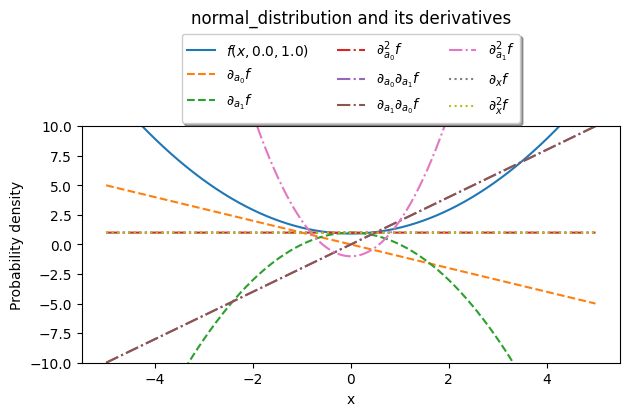

In [5]:
log_jac,log_hess=log_deriv(y=sm.y,jacobian=sm.ja,hessian=sm.ha) #y: probability, j: jacobian, h: hessian, a: parameter, x: observation
log_jx = -sm.jx/sm.y
log_hx = log_jx**2 - sm.hx/sm.y
sm.plot(y=-np.log(sm.y), ja=log_jac, ha=log_hess , jx = log_hx, hx = log_hx, ylim=[-10,10])

The logPDF is simply a parabola, since $\log[f]=(\frac{x-\mu}{\sigma})^{2}$. Note how the cross-partial is now a linear function. These functions are used to construct the geodesics in parameter space as follows.

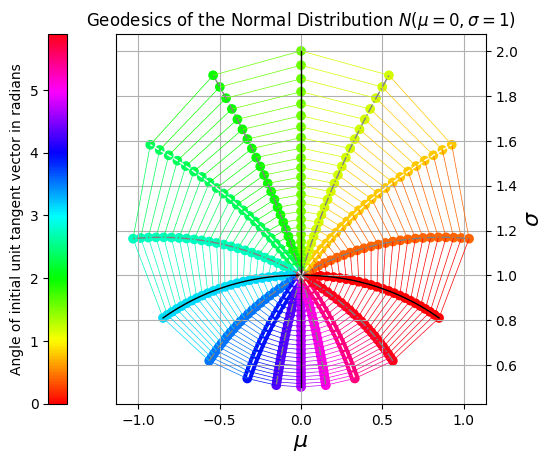

In [6]:
#compute paths of length T using N tangent vectors in a circle of radius R at point a
pos1=sm.geodesics(a=sm.a[0],N=16,T=25,R=1)
sm.plot_geodesics(pos1,
    title=r'Geodesics of the Normal Distribution $N(\mu=0,\sigma=1)$',
    xlabel=r'$\mu$',
    ylabel=r'$\sigma$',
    fontsize=16)

Each tangent vector is curved by the space, as shown by the deformation, stretching, and elongation of the initially orthogonal $(\mu,\sigma)$ axes at the point (0,1).  

The points are solutions to the geodesic equation starting from the given angle (color). The lines connecting points are first-order linear approximations of the bounding polytope for the instantaneous hypersurfaces. In general relativity these are slices of equal proper time for which observers traveling along each geodesic record the same number of ticks of an identical clock.

## Beta Distribution
> Defined on unit interval with two positive parameters.

> https://en.wikipedia.org/wiki/Beta_distribution

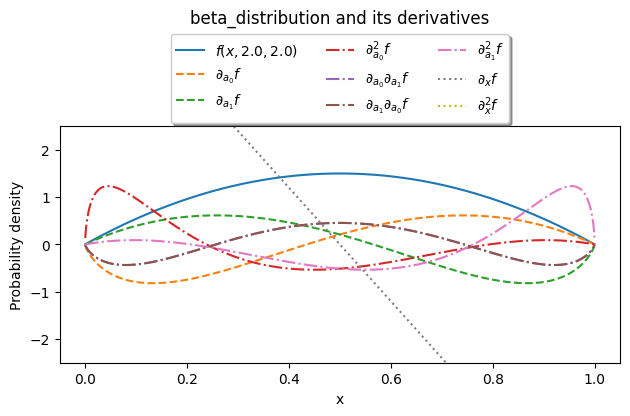

In [4]:
bm=StatisticalManifold(beta_distribution,normalize=True,a=np.array([2.0,2.0]))
bm.plot(ylim=[-2.5,2.5])

And its logarithm:

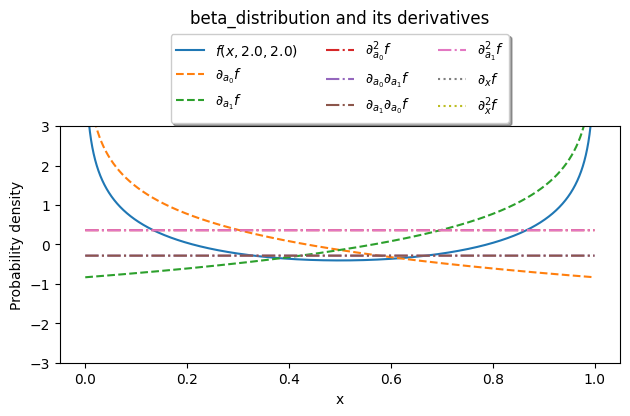

In [5]:
log_jac,log_hess=log_deriv(y=bm.y,jacobian=bm.ja,hessian=bm.ha)
log_jx = -bm.jx/bm.y
log_hx = log_jx**2 - bm.hx/bm.y
bm.plot(y=-np.log(bm.y), ja=log_jac, ha=log_hess , jx = log_hx, hx = log_hx, ylim=[-3,3])

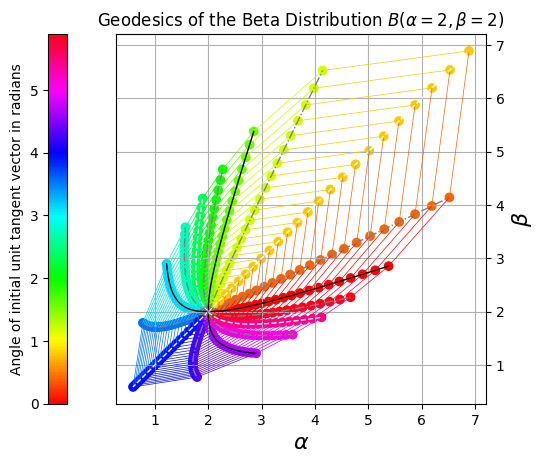

In [7]:
pos2=bm.geodesics()
bm.plot_geodesics(pos2,
    title=r'Geodesics of the Beta Distribution $B(\alpha=2,\beta=2)$',
    xlabel=r'$\alpha$',
    ylabel=r'$\beta$',
    fontsize=16)

To get a cleaner sense of how the tangent vectors are mapped, plot only the diagonals and right angles:

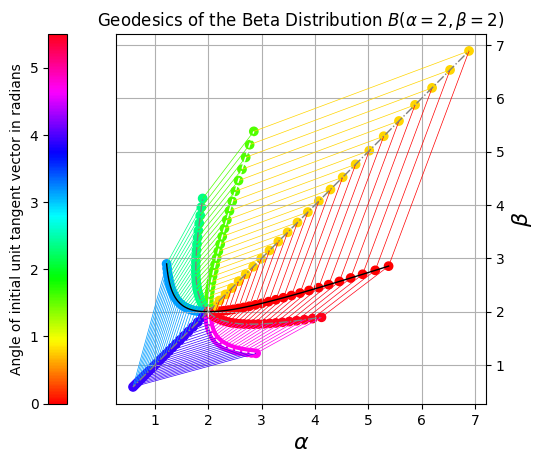

In [8]:
bm.plot_geodesics(pos2[::2],
    title=r'Geodesics of the Beta Distribution $B(\alpha=2,\beta=2)$',
    xlabel=r'$\alpha$',
    ylabel=r'$\beta$',
    fontsize=16)

## Defining a Statistical Manifold
> You can define your own SMs as follows. Consider the Exponentiated generalized Pareto distribution, defined at https://en.wikipedia.org/wiki/Generalized_Pareto_distribution#Exponentiated_generalized_Pareto_distribution

In [8]:
#The relevant terms are shown in the wikipedia page
@njit
def pareto_distribution(x,a):
     sigma,zeta=a[0],a[1]
     sigmainv=1.0/sigma
     return np.exp(x)*sigmainv*(1.0+zeta*np.exp(x)*sigmainv)**(-1.0/zeta-1.0)
    
pareto_distribution.f_shape = (1,)
pareto_distribution.a = np.array([1.0,5.0]) #default point
pareto_distribution.x = np.linspace(-10,25,10000) #default x axis
pareto_distribution.x_bounds = real_line
pareto_distribution.a_bounds = np.array([positives,positives])
pareto_distribution.f_bounds = positives

pm=StatisticalManifold(pareto_distribution,normalize=True)

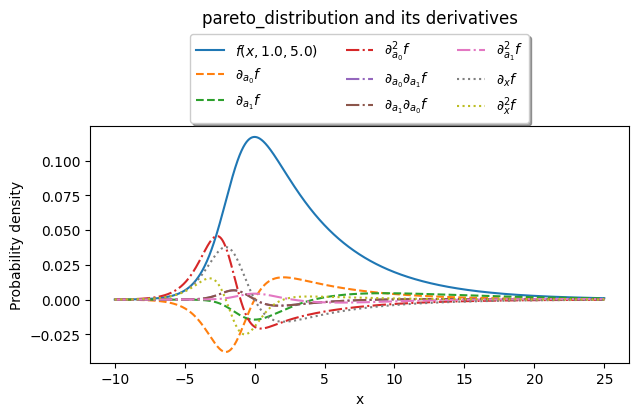

In [9]:
pm.plot()

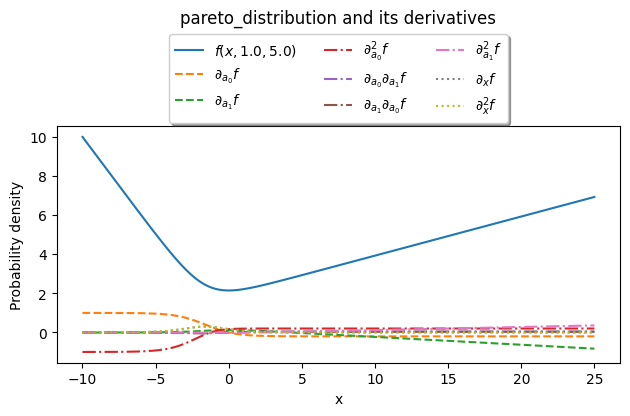

In [10]:
log_jac,log_hess=log_deriv(y=pm.y,jacobian=pm.ja,hessian=pm.ha)
log_jx = -pm.jx/pm.y
log_hx = log_jx**2 - pm.hx/pm.y
pm.plot(y=-np.log(pm.y), ja=log_jac, ha=log_hess , jx = log_hx, hx = log_hx)

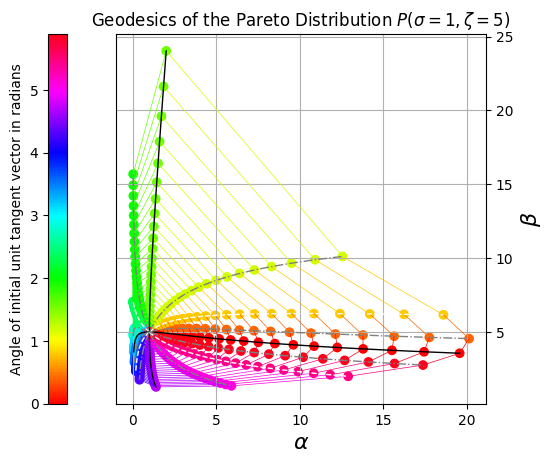

In [11]:
pos3=pm.geodesics()
pm.plot_geodesics(pos3,
    title=r'Geodesics of the Pareto Distribution $P(\sigma=1,\zeta=5)$',
    xlabel=r'$\alpha$',
    ylabel=r'$\beta$',
    fontsize=16)

In [12]:
pm.positive_definite(pm.g)

True

Thus, the above is a valid Riemannian manifold. As such, the curvature tensor and other geometric quantities of interest can be readily calculated and used to evaluate the scaling and continuity properties of the probability distribution, such as for error-correction using geodesics. See statistical_manifolds.py for details.
